# Subject clustering

## Motivation

* The list of subjects taught was found to be the single largest explainer of variance in a tutor's hourly rate.
* This implies that certain subjects are more valuable than others.
* It would be insightful for tutors to know which subjects they should add to their profile in order to make their profile more attractive to potential students.
* However, it is important to only recommend subjects which fall within the expertise of that particular tutor, so a tailored recommendation is required for each tutor.

## Method

* Apply TFIDF vectorization to the subjects string for each tutor.
* Use k-means clusterings as a simple and effective way of grouping similar lists of subjects.
* Use a large number of clusters (minimize the sum of square errors) which leads to a high degree of subject specialization (This reduces the number of unfamiliar subjects that are recommended).
* Rank subjects by overall popularity (in terms of total hours tutored in that subject by all tutors).
* Determine the most popular subjects within each cluster.
* The position of a given subject in the recommendation list is determined by overall popularity weighted by number of times it appears in that cluster.

## Application

* Assign new users to a cluster based on their initial list of subjects.
* Return a list of recommended subjects to that user, which is the top 10 list of recommended subjects for that cluster, which are not already listed by the tutor.

In [1]:
import feat_eng_funcs as fe
import sql_funcs as sf
import cluster_funcs as cf
import pandas as pd
import numpy as np
import pickle
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn.cluster import MiniBatchKMeans

## Preprocessing

* Load in tutor data and tutor subject data.
* Create tutors_joined table, which is tutor ids and a single string containing their list of subjects.
* Numerically encode using TFIDF vectorization.

In [10]:
con = sf.open_sql_con()

sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)

In [3]:
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)
tutors_joined.head()

,tutor_ids,subjects
0,10319,Study Skills Writing Prealgebra Microsoft Powe...
1,10380,Trigonometry Precalculus SAT Math Writing Prea...
2,10504,ESL/ESOL Computer Science Spanish General Comp...
3,10675,Organic Chemistry Precalculus Prealgebra Chemi...
4,10733,ESL/ESOL TOEFL SAT Writing GED Proofreading Li...


In [4]:
tfidf = pickle.load(open('weights/tfidf.sav', 'rb'))
text = tfidf.transform(tutors_joined['subjects'])

## Exploratory analysis

* Use the elbow plot method to identify optimal number of clusters to use in k-means clustering.
* In this case we prefer to completely minimize the SSE, so 28 appears to a suitable number to use.
* We can use PCA or TSNE to reduce the dimensionality of the TFIDF subject matrix, which enables us to visualize the cluster separation in 2D.
* Using TSNE, different types of subjects can be seen to be separated into distinct clusters, with some overlap.
* By extracting the top 10 most common ngrams associated with each cluster, the subject theme of each cluster can be identified.
* While a few clusters have a very wide scope in terms of subject coverage, most can be classified according to clear common themes, e.g. finance (cluster 6), elementary math (cluster 5), history (cluster 18), etc.


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


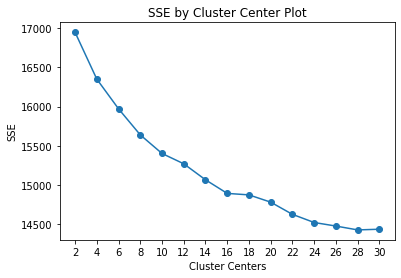

In [5]:
# Fit the k-means elbow plot

cf.find_optimal_clusters(text, 30)

In [6]:
# Fit the k-means model with 28 clusters

kmeans = MiniBatchKMeans(n_clusters=28, init_size=1024, batch_size=2048, random_state=20)
clusters = kmeans.fit_predict(text)

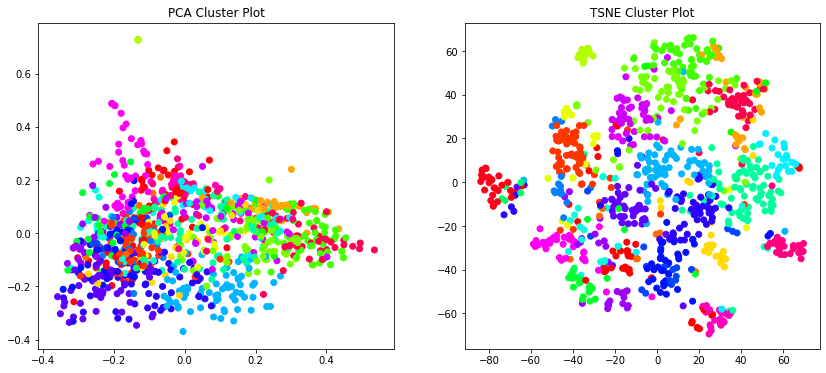

In [7]:
cf.plot_tsne_pca(text, clusters)

In [8]:
cf.get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
autocad,proofreading,statistics,grammar,reading,english,writing,photography,french,spanish

Cluster 1
handwriting,study,study skills,skills,reading,elementary 6th,6th,spelling,phonics,elementary

Cluster 2
sat,english,development,career development,career,reading,writing,college,counseling,college counseling

Cluster 3
differential,differential equations,trigonometry,algebra algebra,precalculus,engineering,calculus algebra,calculus,physics,algebra

Cluster 4
ear,ear training,training,general,music history,general music,history,theory,music theory,music

Cluster 5
6th common,prealgebra elementary,6th algebra,algebra,math,elementary math,math elementary,elementary 6th,6th,elementary

Cluster 6
finance microsoft,finance microeconomics,finance managerial,finance handwriting,finance gre,finance physics,zoology sociology,french,praxis,spanish

Cluster 7
act,sat math,sat,algebra algebra,geometry,elementary math,prealgebra,elementary,math,algebra

Cluster 8
prealgebra geometry,calcu

## Generating the subject recommendation table

* The subject recommendation table will consist of a list of recommended subjects for each cluster.
* First, rank all subjects according to popularity.
* Then, rank phrases associated with each cluster.
* Filter out phrases which don't match with a subject name.
* Multiply the rank of the subject in the cluster with the global popularity rank of that subject.
* Finally, store the table in the postgreSQL database.

In [19]:
def subj_rank(subj):
    '''Returns an array of subjects, ranked by popularity'''

    if subj in subj_pop['subjects_lower'].values:
        return np.where(subj_pop['subjects_lower'].values == subj)[0][0]
    else:
        return 0

In [11]:
# Get the hours tutored in each subject

tutor_subjects['tutor_ids']=tutor_subjects['tutor_ids'].apply(float)
tutor_subjects['tutor_ids']=tutor_subjects['tutor_ids'].apply(int)
tut_hours = pd.merge(tutor_subjects, tutor_data, left_on = 'tutor_ids', right_on = 'tut_id')[['subjects','hours_tutoring']]

subj_pop = tut_hours.groupby('subjects').sum().reset_index()
subj_pop['subjects_lower']=subj_pop['subjects'].str.lower()
subj_pop = subj_pop.sort_values(by='hours_tutoring',ascending=False).reset_index()
subj_pop

,index,subjects,hours_tutoring,subjects_lower
0,15,Algebra 1,9775679.0,algebra 1
1,203,Prealgebra,9043232.0,prealgebra
2,16,Algebra 2,8929434.0,algebra 2
3,118,Geometry,8350533.0,geometry
4,221,SAT Math,8164412.0,sat math
...,...,...,...,...
283,133,Hungarian,9691.0,hungarian
284,264,Thai,9374.0,thai
285,129,Harp,9082.0,harp
286,84,Dutch,6671.0,dutch


In [23]:
# Find the most common ngrams associated with each cluster

labels = tfidf.get_feature_names()
tfidf_df = pd.DataFrame(text.todense()).groupby(clusters).mean().T

cluster_subjects_df = pd.DataFrame()
for clus in range(0,max(clusters)+1):              
    cluster_subjects_df[clus] = np.array([labels[t] for t in np.argsort(tfidf_df[clus].values)[-100:]])
    
cluster_subjects_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,english reading,english writing,skills reading,astronomy trigonometry,reading reading,physics,excel desktop,trigonometry statistics,precalculus trigonometry,prealgebra calculus,...,theater,political,common,political,history,elementary math,photoshop writing,management,probability linear,reading grammar
1,grammar spanish,spelling grammar,handwriting college,python,act math,chemistry biology,excel elementary,ssat,statistics trigonometry,excel,...,history geography,political science,common core,political science,anatomy prealgebra,toefl french,design html,geometry algebra,reading,adhd writing
2,nclex,sat writing,english study,prealgebra linear,proofreading literature,english writing,excel esl,probability precalculus,prealgebra precalculus,microsoft excel,...,history world,needs,praxis,elementary math,chemistry genetics,reading proofreading,macintosh graphic,linear algebra,mechanical engineering,6th special
3,vocabulary proofreading,core reading,core,engineering statistics,general computer,writing spanish,excel finance,sat reading,physics sat,algebra precalculus,...,archaeology,special needs,grammar writing,guitar,psat,study,dreamweaver desktop,linear,mechanical,reading public
4,cooking,sat reading,common core,trigonometry statistics,skills spelling,needs elementary,excel financial,statistics probability,prealgebra logic,math precalculus,...,religion government,special,elementary science,reading american,math prealgebra,study skills,design desktop,ged,math sat,adhd reading


In [24]:
# Filter nonsense phrases and return the most popular subjects in each cluster

most_pop_subjs = []

for i in range(0,max(clusters)+1):
    
    cluster_subjects_df[str(i) +'_rank'] = cluster_subjects_df[i].apply(subj_rank)
    subj_ranks = cluster_subjects_df[i].apply(subj_rank)
    most_pop_subjs.append([subj_pop['subjects'].iloc[t] for t in np.sort(subj_ranks[subj_ranks!=0])])

In [27]:
# Weight the subjects by their position in the global popularity table (subj_pop)

most_pop_subs_weighted = []
ints = np.linspace(1,100,100)

for i in range(0,max(clusters)+1):
    
    cluster_subjects_df[str(i) +'_rank'] = np.multiply(cluster_subjects_df[i].apply(subj_rank).values, ints)
    cluster_subjects_sorted = cluster_subjects_df.sort_values(by = str(i) +'_rank')
    ranked_subs = cluster_subjects_sorted[cluster_subjects_sorted[str(i) +'_rank'] !=0][i].values
    
    most_pop_subs_weighted.append([subj_pop[subj_pop['subjects_lower'] == sub]['subjects'].iloc[0] for sub in ranked_subs])
    
pop_subjs_df = pd.DataFrame(most_pop_subs_weighted).T
pop_subjs_df.columns = ['clus_' + str(i) for i in range(0,28)]
pop_subjs_df.head()

,clus_0,clus_1,clus_2,clus_3,clus_4,clus_5,clus_6,clus_7,clus_8,clus_9,...,clus_18,clus_19,clus_20,clus_21,clus_22,clus_23,clus_24,clus_25,clus_26,clus_27
0,Prealgebra,Geometry,Elementary Math,Prealgebra,ACT Math,Physics,Finite Math,SAT Reading,Prealgebra,Prealgebra,...,Elementary Math,Prealgebra,SAT Math,Elementary Math,Prealgebra,Elementary Math,English,Prealgebra,Reading,Prealgebra
1,Elementary Math,Prealgebra,Statistics,Elementary Math,SAT Math,Trigonometry,Fitness,Prealgebra,GMAT,Microsoft Excel,...,Theater,Geometry,Common Core,Political Science,PSAT,Study Skills,Reading,Linear Algebra,Prealgebra,American History
2,GRE,SAT Writing,Common Core,Python,Prealgebra,Precalculus,Film,SSAT,Geometry,Geometry,...,Archaeology,SAT Math,Elementary Science,Study Skills,Grammar,Writing,Writing,GED,Geometry,SAT Reading
3,NCLEX,SAT Reading,GED,Geometry,Precalculus,Prealgebra,Finance,Vocabulary,SAT Math,SAT Math,...,Bible Studies,Chemistry,Praxis,ACT Reading,Geometry,Grammar,Microsoft Excel,Geometry,SAT Math,SAT Writing
4,Cooking,TOEFL,Business,SAT Math,Geometry,Proofreading,Financial Accounting,English,Precalculus,Precalculus,...,Grammar,ACT Math,Elementary Math,Guitar,SAT Math,Reading,Microsoft Outlook,Study Skills,Mechanical Engineering,ACT English


In [29]:
# Store the final dataframe in the SQL database

engine = sf.create_sql_engine()
pop_subjs_df.to_sql('pop_subjects_weighted', engine, if_exists='replace')

In [31]:
# Save the k-means model for later use

pickle.dump(kmeans, open('weights/kmeans_28.sav', 'wb'))